In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
import plotly.express as px
import plotly

import re

import sklearn
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, Isomap

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import (KMeans, SpectralClustering, 
                             MiniBatchKMeans, AgglomerativeClustering)

from sklearn.metrics import (davies_bouldin_score, 
                            silhouette_score,
                            calinski_harabasz_score,
                            homogeneity_score)

from utils.portfolio import MarkowitzPortfolio, backtesting_universal
from utils.portfolio_metrics import (calculate_measures, show_drawdown_recovery, 
                                     find_max_recovery, find_max_drawdown)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
import plotly.express as px
import plotly

from utils.portfolio_metrics import calculate_measures, show_drawdown_recovery
from datetime import datetime
from datetime import timedelta

In [2]:
with open('config/config.json', 'r') as file:
    config = json.load(file)
    
rs = config['random_state']

# data loading

In [3]:
df = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
print(df.shape)
df.head()

(482, 1196)


,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,sector
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011652,...,-0.019737,-0.012955,-0.016524,-0.007316,-0.009475,-0.005723,0.017351,-0.007921,-0.009695,Healthcare
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,-0.016889,-0.052971,-0.039305,-0.039339,-0.028665,0.034570,0.039120,-0.039216,-0.017143,Industrials
AAP,0.009049,0.036899,0.010631,-0.007042,-0.008080,0.000905,0.021340,0.026472,-0.017595,0.012730,...,-0.013735,-0.002231,-0.008399,-0.021997,-0.017570,0.010337,0.025171,-0.022410,-0.020794,Consumer Cyclical
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000115,-0.000229,0.005680,0.010326,-0.005082,0.016516,...,0.015665,-0.020268,-0.006375,-0.015124,0.002260,0.006566,-0.012652,-0.049119,-0.030039,Technology
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007538,-0.005487,-0.004213,0.010779,0.021427,0.018246,...,-0.006239,-0.010298,0.019243,0.000350,-0.012932,0.003612,0.020322,-0.013001,-0.059627,Healthcare


In [4]:
df_pct = df.drop(['sector'], axis=1).T
df_pct.index = pd.to_datetime(df_pct.index)

tickers_list = df_pct.columns.tolist()

df_pct.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2018-01-03,0.025444,-0.012266,0.009049,-0.000174,0.015649,0.003722,0.017300,0.002211,0.004615,0.012406,...,-0.010834,-0.006693,0.019640,-0.003426,0.012193,-0.000858,0.006932,0.019863,-0.001183,0.004598
2018-01-04,-0.007501,0.006305,0.036899,0.004645,-0.005703,-0.002225,0.017516,-0.001697,0.011841,-0.001094,...,0.005415,-0.007791,0.001384,-0.000149,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964
2018-01-05,0.015988,-0.000380,0.010631,0.011385,0.017408,0.012104,0.015408,0.002890,0.008249,0.004053,...,0.006671,-0.007003,-0.000806,0.014051,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444
2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,0.027086,-0.002882,0.007991,0.001745,...,-0.013314,0.007480,0.004496,0.006781,0.003611,0.001690,0.001905,0.009951,-0.004914,0.011996
2018-01-09,0.024554,-0.000959,-0.008080,-0.000115,0.007538,0.006398,0.009432,0.001700,0.003335,-0.002069,...,0.006778,-0.011667,-0.004246,-0.041728,0.000288,-0.002651,-0.016083,0.030643,0.023509,0.011719


<AxesSubplot:xlabel='Date'>

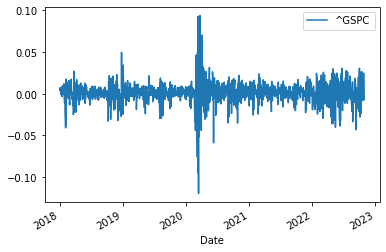

In [5]:
df_market = pd.read_csv(config['ticker_data_sp500'], index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()
df_market.plot()

In [6]:
df_sectors = pd.read_csv(config['tickers_sectors_path'], index_col=0)
df_sectors.nunique()

ticker    492
sector     11
dtype: int64

In [7]:
tickers = df.index.tolist()

In [9]:
# feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
# df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'sector':df['sector']})

# fig = px.scatter(df_tsne, x = 'axis0', y = 'axis1', color="sector", width=800, height=600)
# fig.show()

# Experiments

In [10]:
def make_generator(parameters):
    if not parameters:
        yield dict()
    else:
        key_to_iterate = list(parameters.keys())[0]
        next_round_parameters = {p : parameters[p]
                    for p in parameters if p != key_to_iterate}
        for val in parameters[key_to_iterate]:
            for pars in make_generator(next_round_parameters):
                temp_res = pars
                temp_res[key_to_iterate] = val
                yield temp_res


class ClusteringGridSearch:
    def __init__(self, estimator, param_grid, scoring):

        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring
        
        self.best_params_=dict()
        self.best_estimator_ = None
        self.best_score_ = - 1e-8
        
    def fit(self, X):
        all_params = self.estimator.get_params()
        
        for params in make_generator(self.param_grid):
            
            all_params.update(params)
            self.estimator = self.estimator.set_params(**all_params)
#             self.estimator.fit(X)
#             labels = self.estimator.labels_
            score = self.scoring(self.estimator, X)
    
            if score > self.best_score_:
                self.best_score_ = score
                self.best_estimator_ = self.estimator.fit(X)
                self.best_params_ = params
        

In [11]:
def get_embeddings(models_dict, df_pct):
    embeddings_dict = dict()
    
    for model_name, model in models_dict.items():
        embeddings_dict[model_name] = model.transform(df_pct)
        
    return embeddings_dict

def get_clusters(data,
                 tickers_list,
                 clust_model,
                 make_grid=False, 
                 grid_params=None,
                 grid_metric=None):
    #TO DO Make grid search
    
    
    if make_grid:
        grid_model = ClusteringGridSearch(estimator=clust_model, param_grid=grid_params,
                                            scoring=grid_metric)
        grid_model.fit(data)
        clust_model = grid_model.best_estimator_
    else:
        clust_model.fit(data)
    df_clusters = pd.DataFrame([tickers_list, clust_model.labels_], index=['ticker', 'cluster']).T
    return df_clusters


def select_assets(df_clusters, df_pct, selection_method, n_save=2, **kargs):

    selected_tickers = []
    for cluster in np.unique(df_clusters['cluster'].values):

        df_clusters_loc = df_clusters[df_clusters['cluster'] == cluster]
        list_tickers = df_clusters_loc['ticker'].values.tolist()
        selected_tickers_loc = selection_method(list_tickers, n_save=n_save, df_pct=df_pct, **kargs)
        selected_tickers.extend(selected_tickers_loc)
        
    return selected_tickers

def get_train_test_data(df_pct,
                        train_start_per, 
                        window_train, 
                        window_test):
    
    # slicing data train
            
    train_finish_per = train_start_per + window_train

    train_year_start_per = train_start_per // 12
    train_month_start_per = train_start_per % 12 + 1

    train_year_finish_per = train_finish_per // 12
    train_month_finish_per = train_finish_per % 12 + 1

    mask_train = (df_pct.index > datetime(train_year_start_per, train_month_start_per, 1))
    mask_train = mask_train & (df_pct.index < datetime(train_year_finish_per, train_month_finish_per, 1))
    df_train = df_pct[mask_train]

    # slicing data test
    
    test_finish_per = train_finish_per + window_test
    
    test_year_start_per = train_year_finish_per
    test_month_start_per = train_month_finish_per

    test_year_finish_per = test_finish_per // 12
    test_month_finish_per = test_finish_per % 12 + 1

    #print(train_year_start_per, train_month_start_per,  train_year_finish_per, train_month_finish_per, test_year_finish_per, test_month_finish_per)

    mask_test = (df_pct.index > datetime(test_year_start_per, test_month_start_per, 1)) 
    mask_test = mask_test & (df_pct.index < datetime(test_year_finish_per, test_month_finish_per, 1))
    df_test = df_pct[mask_test]
    
    return df_train, df_test


def backtesting_one_model(df_pct, # df with pct_changes: columns - tick, index - date
                        port_model=MarkowitzPortfolio, #portfolio estimation function
                        window_train=24, # size of train window in months
                        window_test=1,  # size of train window in months
                        train_start_year=2018, #start data year
                        train_start_month=1, #start data month 
                        test_finish_year=2022, #end data year
                        test_finish_month=11, #end data month
                        **kargs):
    
    weights_all = []
    return_portfolio = pd.DataFrame([])
    
    train_start_month = train_start_year * 12 + train_start_month - 1 #indexing from 0
    test_finish_month = test_finish_year * 12 + test_finish_month - 1 #indexing from 0
    train_finish_month = test_finish_month - window_train - window_test + 1
    
    for train_start_per in range(train_start_month, train_finish_month, window_test):
        
        df_train, df_test = get_train_test_data(df_pct, train_start_per, window_train, window_test)
        
        mu = (((df_train + 1).prod()) ** (1 / len(df_train)) - 1).values * 252  # средняя доходность за год (252 раб дня)
        Sigma = df_train.cov().values * 252  # ковариационная матрица за год (252 раб дня)

        port_ = port_model(mu, Sigma, kargs=kargs)
        weights, _ = port_.fit()
        
        weights_all.append(weights)
        
        return_portfolio_loc = pd.DataFrame(df_test.values @ weights, index=df_test.index)
        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
            
    return weights_all, return_portfolio

def clustering_estimation(X, labels):
    scores = []
    scores.append(davies_bouldin_score(X, labels)) # Davies-Bouldin Index
    scores.append(calinski_harabasz_score(X, labels)) # Calinski Harabaz Index
    scores.append(silhouette_score(X, labels)) # Silhouette Coefficient
    return scores

In [12]:
def general_pipeline(df_pct,
                     df_market,
                     embedding_data,
                     
                     clust_params,
                     selection_params,
                     backtesting_params,
                    ):
    
    tickers_list = df_pct.columns.tolist()
    
    #make clustering
    df_clusters = get_clusters(embedding_data, tickers_list, **clust_params)
    clust_metrics = clustering_estimation(df_pct.T.values, df_clusters['cluster'])
    
    #stock selection
    selected_tickers = select_assets(df_clusters, df_pct, **selection_params)
    
    df_pct_loc = df_pct.copy()
    df_pct_loc = df_pct_loc[selected_tickers]
    
    #port_modelling
    weights_all, return_portfolio = backtesting_one_model(df_pct_loc, # df with pct_changes: columns - tick, index - date
                        **backtesting_params)
    
    return weights_all, return_portfolio, clust_metrics
    

In [13]:
def custom_score(estimator, X, y=None):
    estimator.fit(X)
    labels_predicted = estimator.labels_
    score = silhouette_score(X, labels_predicted)
    return score

def selection_sharp(list_tickers, n_save, df_pct, riskfree_rate):
    df_pct = df_pct[list_tickers]
    
    sharp = (df_pct.mean() - riskfree_rate)/df_pct.std()
    selected_tickers = sharp.sort_values(ascending=False).head(n_save).index.tolist()
    
    return selected_tickers

# embeddings

In [14]:
emb_dict =  {'pca': PCA(n_components=100, random_state=rs).fit_transform(df.drop(['sector'], axis=1)),
            'fast_ica': FastICA(n_components=100, random_state=rs).fit_transform(df.drop(['sector'], axis=1))
            }

tickers = df.index.tolist()

df_conv = pd.read_csv(config['nn_conv_data'], index_col=0).loc[tickers]
df_mlp = pd.read_csv(config['nn_mlp_data'], index_col=0).loc[tickers]
df_lstm = pd.read_csv(config['nn_lstm_data'], index_col=0).loc[tickers]

emb_dict['neural_conv'] = df_conv.values
emb_dict['neural_mlp'] = df_mlp.values
emb_dict['neural_lstm'] = df_lstm.values


In [15]:
from ts2vec.ts2vec import TS2Vec

data = np.expand_dims(df_pct.values.T, axis=2)

# Train a TS2Vec model
model = TS2Vec(
    input_dims=1,
    device=0,
    output_dims=100
)
loss_log = model.fit(
    data,
    verbose=True
)

emb_dict['ts2vec'] = model.encode(data, encoding_window='full_series')  # n_instances x output_dims

Epoch #0: loss=3.623498233159383
Epoch #1: loss=3.594729510943095
Epoch #2: loss=3.5778391202290853
Epoch #3: loss=3.563490295410156
Epoch #4: loss=3.5092859427134195
Epoch #5: loss=3.546148983637492
Epoch #6: loss=3.5954375982284548
Epoch #7: loss=3.465514890352885
Epoch #8: loss=3.5493520498275757
Epoch #9: loss=3.556980570157369
Epoch #10: loss=3.4642389456431073
Epoch #11: loss=3.532337522506714
Epoch #12: loss=3.562062382698059
Epoch #13: loss=3.528723136583964
Epoch #14: loss=3.4687657833099363
Epoch #15: loss=3.4695447365442913
Epoch #16: loss=3.4112135966618857
Epoch #17: loss=3.5059076150258384
Epoch #18: loss=3.3783089319864907
Epoch #19: loss=3.468660497665405


In [16]:
for method_name, data in emb_dict.items():
    print(method_name, np.sum(np.isnan(data)), data.shape)

pca 0 (482, 100)
fast_ica 0 (482, 100)
neural_conv 0 (482, 100)
neural_mlp 0 (482, 100)
neural_lstm 0 (482, 100)
ts2vec 0 (482, 100)


# pipeline

In [17]:
riskfree = config['riskless_rate']
riskfree_rate=(1 + riskfree) **(1/252) - 1,
ret_det=(1 + 0.03) **(1/252) - 1,
    
    
clust_params = {'clust_model':KMeans(n_clusters=11, random_state=42),
                'make_grid':False, 
                'grid_params':{
                   'n_clusters':np.arange(9, 14),
                   'init': ['k-means++', 'random'],
                   'algorithm':['auto', 'full', 'elkan']
                },
                'grid_metric':custom_score}


selection_params = {'selection_method':selection_sharp,
                    'n_save':2, 
                    'riskfree_rate':riskfree_rate,}

backtesting_params = {'port_model':MarkowitzPortfolio,
                      'window_train':24, # size of train window in months
                      'window_test':1,  # size of train window in months
                       
                      'train_start_year':2018, #start data year
                      'train_start_month':1, #start data month 
                      'test_finish_year':2022, #end data year
                      'test_finish_month':11, #end data month
                      'ret_det':ret_det
                     }

In [18]:
cluster_metrics_df = pd.DataFrame() 
port_df = pd.DataFrame()    #Считаем портфель Марковица для всех методов кластеризации
dict_weight_methods = dict()

for model_name, embedding_data in tqdm(emb_dict.items()):
    
    weights_all, return_portfolio, cluster_metrics = general_pipeline(
        df_pct,
        df_market,
        embedding_data=embedding_data,
        clust_params=clust_params,
        selection_params=selection_params,
        backtesting_params=backtesting_params)
    
    cluster_metrics_df[model_name] = cluster_metrics
    port_df[model_name] = return_portfolio
    dict_weight_methods[model_name] = weights_all

  0%|          | 0/6 [00:00<?, ?it/s]

### benchmarks

In [19]:
port_df['sp500'] = df_market.loc[port_df.index] 

# economic sectors
clust_econ_sectors = LabelEncoder().fit_transform(df['sector'])
df_clusters = pd.DataFrame([tickers_list, clust_econ_sectors], index=['ticker', 'cluster']).T


selected_tickers = select_assets(df_clusters, df_pct, **selection_params)
df_pct_loc = df_pct[selected_tickers]
weights_all, return_portfolio = backtesting_one_model(df_pct_loc, # df with pct_changes: columns - tick, index - date
                    **backtesting_params)

cluster_metrics_df['sectors'] = clustering_estimation(df_pct.T.values, df_clusters['cluster'])
dict_weight_methods['sectors'] = weights_all
port_df['sectors'] = return_portfolio


# results estimation

In [20]:
def calc_metrics(port_df, df_market, riskfree_rate, port_name='Markovitz'):
    
    result_df = pd.DataFrame()
    
    #Average daily returns
    mean = port_df.mean()
    result_df['AVG_returns'] = mean 

    #Risk
    risk = port_df.std()
    result_df['Risk'] = risk

    #Beta
    var_ = port_df.var()
    cov_ = port_df.cov()
    beta = cov_['sp500']/var_

    result_df['Beta'] = beta

    #Alpha
    alpha = mean - (riskfree_rate + beta*(result_df.loc['sp500', 'AVG_returns'] - riskfree_rate))
    result_df['Alpha'] = alpha
    
    #Sharpe 
    sharpe = (mean - riskfree_rate)/risk
    result_df['Sharpe'] = sharpe

    #VaR(95%)
    VaR = - risk*1.65
    result_df['VaR(95%)'] = VaR
    
    #Drawdown and Recovery
    portfolio_value = (port_df+1).cumprod() #датафрейм со "стоимостью" портфеля

    recovery = []
    drawdown = []
    for i in range(len(port_df.columns)):
        recovery.append(find_max_recovery(portfolio_value.iloc[:,i])[0])
        drawdown.append(find_max_drawdown(portfolio_value.iloc[:,i])[0])
    
    result_df['Drawdown(%)'] = drawdown
    result_df['Recovery(days)'] = recovery
     
    return result_df

In [21]:
all_metrics = calc_metrics(port_df, df_market, riskfree_rate)
all_metrics

,AVG_returns,Risk,Beta,Alpha,Sharpe,VaR(95%),Drawdown(%),Recovery(days)
pca,0.001365,0.023348,0.527565,1.169806e-03,0.053431,-0.038524,-52.642869,202
fast_ica,-0.000010,0.020395,0.625771,-2.198553e-04,-0.006261,-0.033651,-55.592773,331
neural_conv,0.001161,0.023985,0.531067,9.655549e-04,0.043517,-0.039576,-53.319042,195
neural_mlp,0.002304,0.029036,0.401290,2.127375e-03,0.075303,-0.047909,-61.967517,73
neural_lstm,0.001586,0.020291,0.632199,1.375469e-03,0.072376,-0.033480,-27.793733,85
ts2vec,0.001574,0.023195,0.527303,1.379129e-03,0.062805,-0.038273,-47.588698,192
sp500,0.000265,0.016120,1.000000,3.252607e-19,0.009137,-0.026598,-33.924960,179
sectors,0.001177,0.020758,0.605734,9.709456e-04,0.051072,-0.034251,-42.313929,185


In [22]:
cluster_metrics_df = cluster_metrics_df.rename(index=dict(zip(list(range(3)), ['DB', 'HC', 'Sil']))).T
cluster_metrics_df

,DB,HC,Sil
pca,2.994599,18.344697,0.036457
fast_ica,4.119657,4.976354,-0.038924
neural_conv,4.370061,10.041375,-0.017983
neural_mlp,5.336673,8.906414,-0.044381
neural_lstm,7.138803,3.276008,-0.041314
ts2vec,7.341633,6.144513,-0.047008
sectors,3.744944,10.966541,-0.013596
